This notebook uses a "Mini Kaggle Alzheimers Dataset" for faster training and demonstrates a template for applying SMOTE/Z-score techniques to address class imbalance in image classification problems.

Please use "Kaggle Alzheimers Dataset" for your model training


In [ ]:
# mount gdrive with this code
from google.colab import drive
drive.mount('/content/drive')
#below where the file is in gdrive, change with your
data_path =  "/content/drive/My Drive/AI - Fall 2024/Final Project v.2/Datasets"

Mounted at /content/drive


# PART 0 STARTS ___________

In [ ]:
# import packages
import tensorflow as tf
from math import ceil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.models import load_model

# from imblearn.over_sampling import SMOTE

from IPython.display import display
from PIL import Image

In [ ]:
Original_Train ='/content/drive/My Drive/AI - Fall 2024/Final Project v.2/Datasets/Kaggle Alzheimers Dataset/train'
Original_Test = '/content/drive/My Drive/AI - Fall 2024/Final Project v.2/Datasets/Kaggle Alzheimers Dataset/test'

Augmented_Train = '/content/drive/My Drive/AI - Fall 2024/Final Project v.2/Datasets/Combined Dataset/train'
# Augmented_Test = '/content/drive/My Drive/AI - Fall 2024/Final Project v.2/Datasets/Combined Dataset/test'

In [ ]:
batch_size = 32
numClasses = 4
img_height, img_width, chan_count = 224,224,3


data = ImageDataGenerator(rescale=1.0 / 255)

training_data = data.flow_from_directory(
    Original_Train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    # subset='training',
    shuffle=True
)

training_data_noshuffle = data.flow_from_directory(
   Original_Train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    # subset='training',
    shuffle=False
)

test_data = data.flow_from_directory(
    Original_Test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    # subset='validation',
    shuffle=False
)


Found 5121 images belonging to 4 classes.
Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
training_data.class_indices

{'MildImpairment': 0,
 'ModerateImpairment': 1,
 'NoImpairment': 2,
 'VeryMildImpairment': 3}

In [ ]:
# Get the class labels from the training data
train_labels = training_data.labels

# Count the occurrences of each class
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Print the results
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} data points")

Class 0: 717 data points
Class 1: 52 data points
Class 2: 2560 data points
Class 3: 1792 data points


Determine majority and minority class

In [ ]:
# Get the class labels from the training data
train_labels = training_data.labels

# Count the occurrences of each class
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Find the majority class (the class with the highest count)
majority_class = [unique_classes[np.argmax(class_counts)]]  # Class with the highest count

# Find the minority classes (all other classes)
minority_class = [cls for cls in unique_classes if cls not in majority_class]

# Print the results
print(f"Majority Class: {majority_class}")
print(f"Minority Classes: {minority_class}")


Majority Class: [2]
Minority Classes: [0, 1, 3]


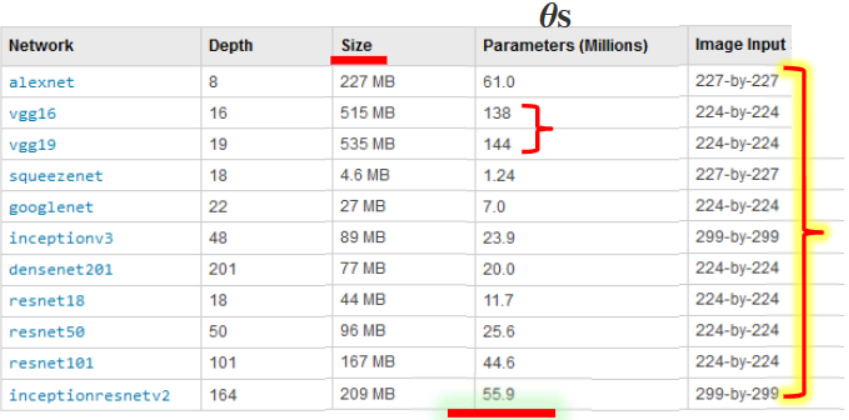

# PART 0 ENDS ________

# RECALL PART 3 RESULTS

In [ ]:
# Specify the directory
NB_name= 'InceptionV3-24Nov'
save_dir = '/content/drive/My Drive/AI - Fall 2024/Final Project v.2/ModelCheckpoint'

# Define unique filenames based on the notebook name
combined_training_data_file = f"{save_dir}/{NB_name}_combined_training_data.npy"
combined_training_labels_file = f"{save_dir}/{NB_name}_combined_training_labels.npy"
Zcode_testing_file = f"{save_dir}/{NB_name}_Zcode_testing.npy"
combined_training_labels_noshuffle_file = f"{save_dir}/{NB_name}_combined_training_labels_noshuffle.npy"
combined_training_data_noshuffle_file = f"{save_dir}/{NB_name}_combined_training_data_noshuffle.npy"


# Load the arrays
combined_training_data = np.load(combined_training_data_file)
combined_training_labels = np.load(combined_training_labels_file)
Zcode_testing = np.load(Zcode_testing_file)
combined_training_labels_noshuffle = np.load(combined_training_labels_noshuffle_file)
combined_training_data_noshuffle = np.load(combined_training_data_noshuffle_file)

# PART 4 STARTS _________________

In [ ]:
print('Combined Training Data')
print(combined_training_data)
print(combined_training_labels)
print('\n')

print('Testing')
print(Zcode_testing)
print('\n')

print('Combined Training Data No Shuffle')
print(combined_training_data_noshuffle)
print(combined_training_labels_noshuffle)


Combined Training Data
[[0.         0.         0.         ... 3.7851996  0.75289553 1.2610432 ]
 [0.         0.         0.         ... 0.7920182  1.6478354  0.        ]
 [0.         0.         0.         ... 1.449706   1.1776924  1.0200361 ]
 ...
 [0.         0.         0.22728989 ... 0.8288639  0.         1.6307728 ]
 [0.20933205 0.         0.         ... 2.9351938  1.1639774  0.9222177 ]
 [0.         0.         0.         ... 1.6350313  1.347389   1.4509774 ]]
[2 2 2 ... 3 3 3]


Testing
[[0.         0.         0.         ... 2.3818862  1.737365   1.7087429 ]
 [0.19008346 0.         0.         ... 1.236031   0.         0.86117244]
 [0.10828233 0.         0.         ... 0.7946604  0.         1.4064183 ]
 ...
 [0.         0.         0.         ... 1.6468735  0.7024328  0.89814115]
 [0.         0.         0.         ... 0.89193    0.         2.698362  ]
 [0.         0.         0.         ... 1.7087692  1.3522965  2.1767578 ]]


Combined Training Data No Shuffle
[[0.00000000e+00 0.000000

In [ ]:
print('Shape of combined training data after Zcode/SMOTE ', combined_training_data.shape)
print('Labels of combined training data ', combined_training_labels)
print('Shape of Zcode testing used to train classifier model ', Zcode_testing.shape)
print('Shape of combined training data no shuffle for classification report ', combined_training_data_noshuffle.shape)
print('Labels of combined training data no shuffle ', combined_training_labels_noshuffle.shape)

Shape of combined training data after Zcode/SMOTE  (10240, 51200)
Labels of combined training data  [2 2 2 ... 3 3 3]
Shape of Zcode testing used to train classifier model  (1279, 51200)
Shape of combined training data no shuffle for classification report  (10240, 51200)
Labels of combined training data no shuffle  (10240,)


5. Create a new separated model (classifier), which is a new model to train your processed training_data and Zcode(testing_dataset)

5a. One-hot encoded for classes in combined_training_lables and test_labels.

Note that: the combined_training_labels here is the training_data after Zcode and smote, the test_labels here is after the Zcode


In [ ]:
# Step 1: Prepare Labels
# One-hot encode labels for multi-class classification
test_labels = test_data.classes
num_classes = len(np.unique(combined_training_labels))

training_labels_onehot = to_categorical(combined_training_labels, num_classes)
test_labels_onehot = to_categorical(test_labels, num_classes)  # Assuming test_labels is available


In [ ]:
print(num_classes)

4


5b. Create Classifier to classify after processing with Zcode and SMOTE

In [ ]:
# Dynamically get the shape from combined_training_data
input_shape = combined_training_data.shape[1:]  # Exclude the batch size dimension

from tensorflow.keras.regularizers import l2

# # Input layer
# visibleL = Input(shape=input_shape, name='Input')

# hidden1 = Dense(8192, activation='relu', name='Hidden1')(visibleL)
# hidden1_bn = BatchNormalization(name='Hidden1_BN')(hidden1)
# hidden1_do = Dropout(0.3, name='Hidden1_DO')(hidden1_bn)

# hidden2 = Dense(4096, activation='relu', name='Hidden2')(hidden1_do)
# hidden2_bn = BatchNormalization(name='Hidden2_BN')(hidden2)
# hidden2_do = Dropout(0.3, name='Hidden2_DO')(hidden2_bn)

# hidden3 = Dense(2048, activation='relu', name='Hidden3')(hidden2_do)
# hidden3_bn = BatchNormalization(name='Hidden3_BN')(hidden3)
# hidden3_do = Dropout(0.3, name='Hidden3_DO')(hidden3_bn)

# hidden4 = Dense(1024, activation='relu', name='Hidden4')(hidden3_do)
# hidden4_bn = BatchNormalization(name='Hidden4_BN')(hidden4)
# hidden4_do = Dropout(0.3, name='Hidden4_DO')(hidden4_bn)

# # Output layer
# outputL = Dense(num_classes, activation='softmax', name='Output')(hidden3_do)


In [ ]:
# # Input layer
# visibleL = Input(shape=input_shape, name='Input')

# hidden1 = Dense(8192, activation='relu', name='Hidden1')(visibleL)
# # hidden1_bn = BatchNormalization(name='Hidden1_BN')(hidden1)
# hidden1_do = Dropout(0.3, name='Hidden1_DO')(hidden1)

# hidden2 = Dense(4096, activation='relu', name='Hidden2')(hidden1_do)
# # hidden2_bn = BatchNormalization(name='Hidden2_BN')(hidden2)
# hidden2_do = Dropout(0.3, name='Hidden2_DO')(hidden2)

# hidden3 = Dense(2048, activation='relu', name='Hidden3')(hidden2_do)
# # hidden3_bn = BatchNormalization(name='Hidden3_BN')(hidden3)
# hidden3_do = Dropout(0.3, name='Hidden3_DO')(hidden3)

# hidden4 = Dense(1024, activation='relu', name='Hidden4')(hidden3_do)
# # hidden4_bn = BatchNormalization(name='Hidden4_BN')(hidden4)
# hidden4_do = Dropout(0.3, name='Hidden4_DO')(hidden4)

# # Output layer
# outputL = Dense(num_classes, activation='softmax', name='Output')(hidden3_do)

In [ ]:
visibleL = Input(shape=input_shape, name='Input')

hidden1 = Dense(1024, activation='relu', name='Hidden1')(visibleL)
hidden1_bn = BatchNormalization(name='Hidden1_BN')(hidden1)
hidden1_do = Dropout(0.3, name='Hidden1_DO')(hidden1_bn)

hidden2 = Dense(512, activation='relu', name='Hidden2')(hidden1_do)
hidden2_bn = BatchNormalization(name='Hidden2_BN')(hidden2)
hidden2_do = Dropout(0.3, name='Hidden2_DO')(hidden2_bn)

outputL = Dense(num_classes, activation='softmax', name='Output')(hidden2_do)

# Training goes to 0.9, Testing goes to 0.44 highest. This is more stable

In [ ]:
# # Modify the architecture and include regularization
# visibleL = Input(shape=input_shape, name='Input')

# hidden1 = Dense(512, activation='relu', kernel_regularizer=l2(0.001), name='Hidden1')(visibleL)
# hidden1_bn = BatchNormalization(name='Hidden1_BN')(hidden1)
# hidden1_do = Dropout(0.5, name='Hidden1_DO')(hidden1_bn)  # Increased dropout

# hidden2 = Dense(256, activation='relu', kernel_regularizer=l2(0.001), name='Hidden2')(hidden1_do)  # Reduced units
# hidden2_bn = BatchNormalization(name='Hidden2_BN')(hidden2)
# hidden2_do = Dropout(0.5, name='Hidden2_DO')(hidden2_bn)  # Increased dropout

# outputL = Dense(num_classes, activation='softmax', name='Output')(hidden2_do)
# classifier = Model(inputs=visibleL, outputs=outputL)

In [ ]:
classifier = Model(inputs=visibleL, outputs=outputL)

In [ ]:
# Print summary to verify layer names
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 51200)]           0         
                                                                 
 Hidden1 (Dense)             (None, 1024)              52429824  
                                                                 
 Hidden1_BN (BatchNormaliza  (None, 1024)              4096      
 tion)                                                           
                                                                 
 Hidden1_DO (Dropout)        (None, 1024)              0         
                                                                 
 Hidden2 (Dense)             (None, 512)               524800    
                                                                 
 Hidden2_BN (BatchNormaliza  (None, 512)               2048      
 tion)                                                       

In [ ]:
# Step 3: Compile the model
classifier.compile(optimizer=Adam(learning_rate= 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_save = ModelCheckpoint('/content/drive/My Drive/AI - Fall 2024/Final Project v.2/ModelCheckpoint/classifier_model.keras', save_best_only=False, monitor='val_accuracy', mode='max')

In [ ]:
print(combined_training_data)
print(training_labels_onehot)

[[0.         0.         0.         ... 3.7851996  0.75289553 1.2610432 ]
 [0.         0.         0.         ... 0.7920182  1.6478354  0.        ]
 [0.         0.         0.         ... 1.449706   1.1776924  1.0200361 ]
 ...
 [0.         0.         0.22728989 ... 0.8288639  0.         1.6307728 ]
 [0.20933205 0.         0.         ... 2.9351938  1.1639774  0.9222177 ]
 [0.         0.         0.         ... 1.6350313  1.347389   1.4509774 ]]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [ ]:
print(Zcode_testing)
print(test_labels_onehot)

[[0.         0.         0.         ... 2.3818862  1.737365   1.7087429 ]
 [0.19008346 0.         0.         ... 1.236031   0.         0.86117244]
 [0.10828233 0.         0.         ... 0.7946604  0.         1.4064183 ]
 ...
 [0.         0.         0.         ... 1.6468735  0.7024328  0.89814115]
 [0.         0.         0.         ... 0.89193    0.         2.698362  ]
 [0.         0.         0.         ... 1.7087692  1.3522965  2.1767578 ]]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [ ]:
# Step 4: Train the Model
classifier.fit(
    combined_training_data,
    training_labels_onehot,
    epochs=100,
    batch_size=50,
    validation_data = (Zcode_testing,test_labels_onehot),
    callbacks=[model_save]
)




Epoch 1/100
205/205 [==============================] - 53s 252ms/step - loss: 1.2827 - accuracy: 0.5113 - val_loss: 1.9495 - val_accuracy: 0.3417
Epoch 2/100
205/205 [==============================] - 47s 232ms/step - loss: 0.8712 - accuracy: 0.6406 - val_loss: 1.4369 - val_accuracy: 0.3698
Epoch 3/100
205/205 [==============================] - 47s 232ms/step - loss: 0.7116 - accuracy: 0.7120 - val_loss: 1.5967 - val_accuracy: 0.3276
Epoch 4/100
205/205 [==============================] - 48s 232ms/step - loss: 0.6064 - accuracy: 0.7493 - val_loss: 1.5216 - val_accuracy: 0.3769
Epoch 5/100
205/205 [==============================] - 47s 230ms/step - loss: 0.4996 - accuracy: 0.7967 - val_loss: 1.6568 - val_accuracy: 0.3683
Epoch 6/100
205/205 [==============================] - 48s 234ms/step - loss: 0.4311 - accuracy: 0.8254 - val_loss: 1.5649 - val_accuracy: 0.4199
Epoch 7/100
205/205 [==============================] - 48s 234ms/step - loss: 0.3773 - accuracy: 0.8517 - val_loss: 1.8378 -

5c. Plot accuracy and lost of combined_training_data and Zcode_testing

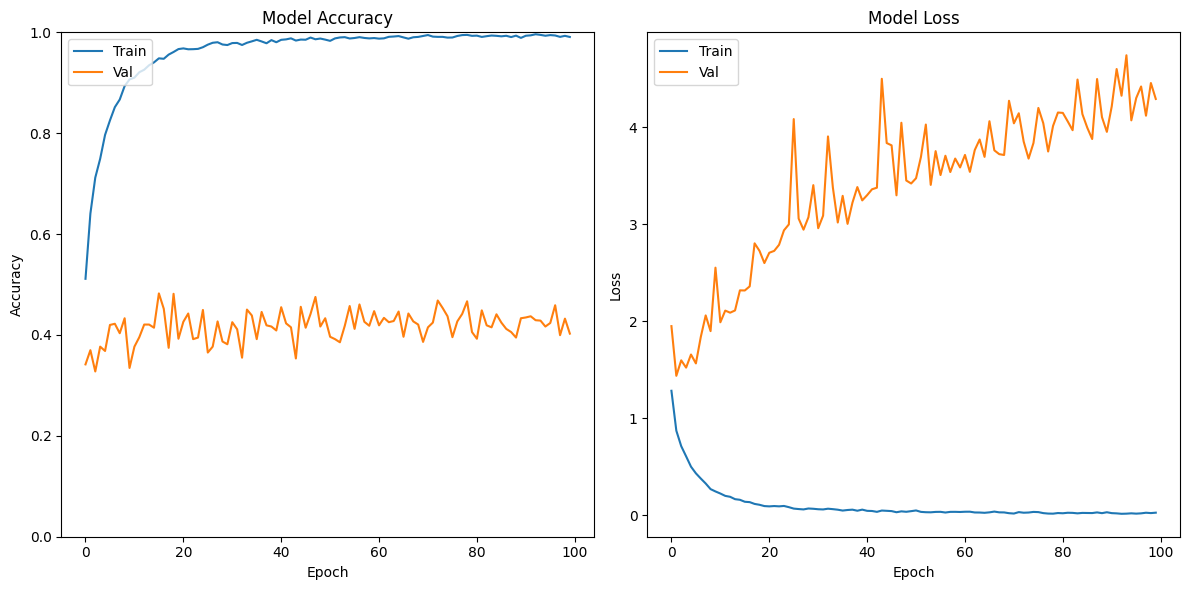

In [ ]:
history2 = classifier.history.history

plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history2['accuracy'])
plt.plot(history2['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper left')
plt.ylim(0,1)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.tight_layout()  # Adjust spacing between plots
plt.show()

5d. Classification Report of Training and Testing

In [ ]:
# Get unique class labels and generate target names dynamically
unique_classes = np.unique(combined_training_labels_noshuffle)
target_names = [f"Class {cls}" for cls in unique_classes]

In [ ]:
testing_labels = test_data.classes

In [ ]:
# Predict training dataset
train_predictions = classifier.predict(combined_training_data_noshuffle)
train_predicted_classes = np.argmax(train_predictions, axis=1)  # Convert probabilities to class indices

# Predict test dataset
test_predictions = classifier.predict(Zcode_testing)
test_predicted_classes = np.argmax(test_predictions, axis=1)  # Convert probabilities to class indices

# Classification report for training data
print("Classification Report - Training Data:")
print(classification_report(combined_training_labels_noshuffle, train_predicted_classes, target_names=target_names))

# Classification report for test data
print("Classification Report - Test Data:")
print(classification_report(testing_labels, test_predicted_classes, target_names=target_names))

40/40 [==============================] - 0s 11ms/step
Classification Report - Training Data:
              precision    recall  f1-score   support

     Class 0       0.26      0.16      0.20      2560
     Class 1       0.43      0.03      0.05      2560
     Class 2       0.26      0.50      0.34      2560
     Class 3       0.26      0.36      0.30      2560

    accuracy                           0.26     10240
   macro avg       0.30      0.26      0.22     10240
weighted avg       0.30      0.26      0.22     10240

Classification Report - Test Data:
              precision    recall  f1-score   support

     Class 0       0.18      0.19      0.18       179
     Class 1       0.00      0.00      0.00        12
     Class 2       0.53      0.44      0.48       640
     Class 3       0.36      0.45      0.40       448

    accuracy                           0.40      1279
   macro avg       0.27      0.27      0.27      1279
weighted avg       0.42      0.40      0.41      1279



6. Graph tsne of Training and Testing dataset

6a. Create a model_3 from classifier model (step #5) to get Zcode of combined_training_data and Zcode_testing

In [ ]:
model_3 = Model(inputs=classifier.input, outputs=classifier.get_layer('Hidden2_DO').output)

6b. Zcode

In [ ]:
# Feature extraction of combined_training_data and Zcode_testing
tsne_Zcode_training = model_3.predict(combined_training_data_noshuffle)
tsne_Zcode_testing = model_3.predict(Zcode_testing)

print('Shape of Combined Training Data-NoShuffle after feature extraction for tsne graph is: ', tsne_Zcode_training.shape)
print('Shape of Testing Data after feature extraction for tsne graph is',tsne_Zcode_testing.shape)

40/40 [==============================] - 0s 10ms/step
Shape of Combined Training Data-NoShuffle after feature extraction for tsne graph is:  (10240, 512)
Shape of Testing Data after feature extraction for tsne graph is (1279, 512)


6c. tsne on the Zcode (step #6b)

In [ ]:
# tsne Z_code to 2-D

# Define TSNE instance
tsne_train = TSNE(n_components=2, verbose=1, random_state=0, perplexity=min(30, tsne_Zcode_training.shape[0] - 1))
tsne_test = TSNE(n_components=2, verbose=1, random_state=0, perplexity=min(30, tsne_Zcode_testing.shape[0] - 1))

# Define TSNE instance for testing data with adjusted perplexity
tsne_training = tsne_train.fit_transform(tsne_Zcode_training)
tsne_testing = tsne_test.fit_transform(tsne_Zcode_testing)

print("TSNE results for training data:", tsne_training.shape)
print("TSNE results for testing data:", tsne_testing.shape)

X1,y1 = tsne_training[:,0], tsne_training[:,1]
X2,y2 = tsne_testing[:,0], tsne_testing[:,1]


print(X1.shape, y1.shape)
print(X2.shape, y2.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10240 samples in 0.003s...
[t-SNE] Computed neighbors for 10240 samples in 0.462s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10240
[t-SNE] Computed conditional probabilities for sample 2000 / 10240
[t-SNE] Computed conditional probabilities for sample 3000 / 10240
[t-SNE] Computed conditional probabilities for sample 4000 / 10240
[t-SNE] Computed conditional probabilities for sample 5000 / 10240
[t-SNE] Computed conditional probabilities for sample 6000 / 10240
[t-SNE] Computed conditional probabilities for sample 7000 / 10240
[t-SNE] Computed conditional probabilities for sample 8000 / 10240
[t-SNE] Computed conditional probabilities for sample 9000 / 10240
[t-SNE] Computed conditional probabilities for sample 10000 / 10240
[t-SNE] Computed conditional probabilities for sample 10240 / 10240
[t-SNE] Mean sigma: 5.427266
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.283890
[t-SNE] KL 

6d. Plot tsne

[Text(0.5, 1.0, 'tsne of Zcode of testing')]

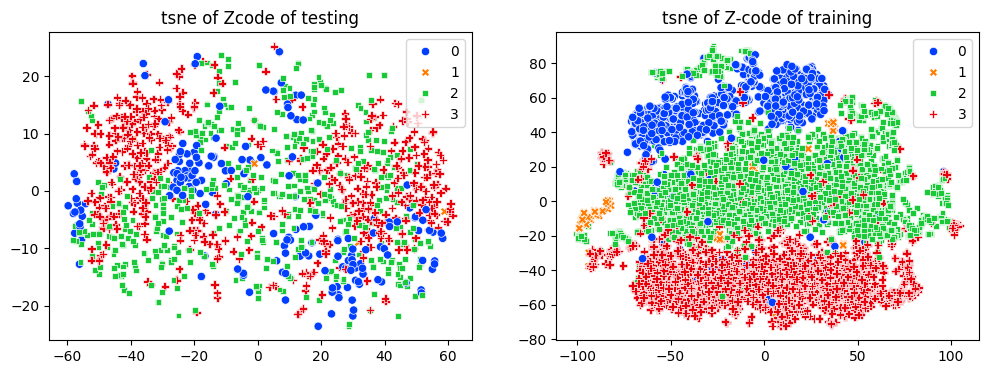

In [ ]:

y_1D_train = train_predicted_classes
y_1D_test = test_predicted_classes

f, axes = plt.subplots(1, 2,figsize=(12,4))
palette = sns.color_palette("bright", 4)  # color

sns.scatterplot(x = X1, y = y1, palette = palette, style = y_1D_train, hue = y_1D_train, legend = 'full', ax = axes[1]).set(title='tsne of Z-code of training')
sns.scatterplot(x = X2, y = y2, palette = palette, style = y_1D_test, hue = y_1D_test, legend = 'full', ax = axes[0]).set(title='tsne of Zcode of testing')



7. ROC Curve

In [ ]:
# Compute ROC curve and ROC area for each class
## Calculate ROC curves and AUCs for all classes
roc_curves = {}
for i, class_label in enumerate(unique_classes):
    fpr, tpr, _ = roc_curve(test_labels, test_predictions[:, i], pos_label=class_label)
    roc_auc = auc(fpr, tpr)
    roc_curves[class_label] = (fpr, tpr, roc_auc)
    print(f"roc_auc_{class_label}: {roc_auc:.2f}")

roc_auc_0: 0.59
roc_auc_1: 0.50
roc_auc_2: 0.53
roc_auc_3: 0.53


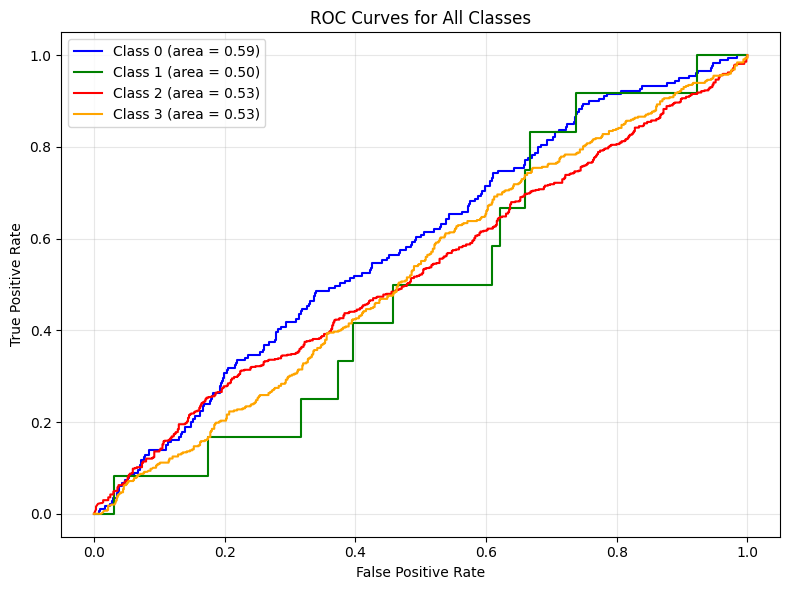

In [ ]:
# Define a list of colors
colors = ['blue', 'green', 'red', 'orange']

# Plot ROC curves for all classes
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(unique_classes):
    fpr, tpr, roc_auc = roc_curves[class_label]
    plt.plot(
        fpr, tpr,
        label=f'Class {class_label} (area = {roc_auc:.2f})',
        color=colors[i % len(colors)]
    )

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print('The run is completed!')

The run is completed!
